<a href="https://colab.research.google.com/github/marcusaxelsson1/Advanced_NN/blob/main/UNet3_Copy2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DOWNLOADING DATA FROM DRIVE IF ON COLAB

In [ ]:
%pip install gdown
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1RfN4XDprnJCyq7sFjCbj1o68qDv4dIjg'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)
!unzip dataset.zip

In [3]:
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split

au_files = sorted(glob('/content/Output/Au_paded/*.png'))
tp_files = sorted(glob('/content/Output/Tp_paded/*.png'))
gt_files = sorted(glob('/content/Output/Gt_paded/*.png'))

# Assuming filenames are aligned, you can create a dataframe like this:
df = pd.DataFrame({
    'photoshopped': tp_files,
    'ground_truth': gt_files
})

# Split into train and test sets first
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42)  # 20% for testing

# Split the remaining data into train and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.15, random_state=42)  # 25% of 80% = 20% of total

# You now have three sets:
# train_df with 60% of the data, val_df with 20%, and test_df with 20%
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Testing set size:", len(test_df))

Training set size: 2575
Validation set size: 455
Testing set size: 337


In [4]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm

def compute_mean_std(df, column_name, grayscale=False):
    # Define transformation: optionally convert to grayscale
    if grayscale:
        transform = transforms.Compose([
            transforms.Grayscale(),  # Convert to grayscale
            transforms.ToTensor()
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor()
        ])

    sum_ = 0
    sum_sq = 0
    n_images = 0

    for file in tqdm(df[column_name]):
        image = Image.open(file)
        image_tensor = transform(image)
        sum_ += torch.sum(image_tensor, dim=[1, 2])  # Sum over height and width for each channel
        sum_sq += torch.sum(image_tensor ** 2, dim=[1, 2])
        n_images += image_tensor.shape[1] * image_tensor.shape[2]  # Total number of pixels per channel

    mean = sum_ / n_images
    std = (sum_sq / n_images - mean ** 2) ** 0.5  # std dev calculation

    return mean, std

# Example usage with your DataFrame and the 'photoshopped' column
img_mean, img_sd = compute_mean_std(train_df, 'photoshopped')
print(f"Image Mean: {img_mean}")
print(f"Image Std: {img_sd}")

100%|██████████| 2575/2575 [00:13<00:00, 189.79it/s]


Image Mean: tensor([0.2652, 0.2573, 0.2287])
Image Std: tensor([0.2948, 0.2862, 0.2824])


# IF HAVING THE DATA LOCALLY

In [ ]:
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split

# Replace 'path_to_images' with your actual folder path
au_files = sorted(glob('c:/Users/Marcus/Documents/Avancerade NN/Project/dataset/Output/Au_paded/*.png'))
tp_files = sorted(glob('c:/Users/Marcus/Documents/Avancerade NN/Project/dataset/Output/Tp_paded/*.png'))
gt_files = sorted(glob('c:/Users/Marcus/Documents/Avancerade NN/Project/dataset/Output/Gt_paded/*.png'))



# Assuming filenames are aligned, you can create a dataframe like this:
df = pd.DataFrame({
    'photoshopped': tp_files,
    'ground_truth': gt_files
})

# Split into train and test sets first
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42)  # 20% for testing

# Split the remaining data into train and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.15, random_state=42)  # 25% of 80% = 20% of total

# You now have three sets:
# train_df with 60% of the data, val_df with 20%, and test_df with 20%
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Testing set size:", len(test_df))

Training set size: 2575
Validation set size: 455
Testing set size: 337


# Visualizing the data in the dataframe

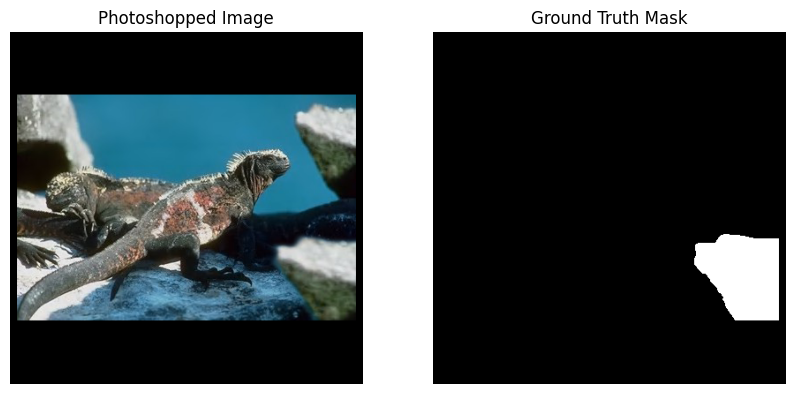

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import random


# Function to display a row of images (photoshopped and ground truth)
def show_images(photoshopped_path, ground_truth_path):
    # Set up the matplotlib figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    titles = ['Photoshopped Image', 'Ground Truth Mask']

    # Load the photoshopped image
    photoshopped_image = Image.open(photoshopped_path)
    axes[0].imshow(photoshopped_image)
    axes[0].set_title(titles[0])
    axes[0].axis('off')  # Hide the axis ticks and labels

    # Load the ground truth mask
    ground_truth_image = Image.open(ground_truth_path)
    axes[1].imshow(ground_truth_image)
    axes[1].set_title(titles[1])
    axes[1].axis('off')  # Hide the axis ticks and labels

    plt.show()

# Display a random image
random_index = random.randint(0, len(tp_files) - 1)
show_images(df['photoshopped'][random_index], df['ground_truth'][random_index])


# Preprocessing of data

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm

def compute_mean_std(directory, file_list, grayscale=False):
    # Define transformation: optionally convert to grayscale
    if grayscale:
        transform = transforms.Compose([
            #transforms.Resize((256, 256)),  # Resize images if necessary
            transforms.Grayscale(),         # Convert to grayscale
            transforms.ToTensor()
        ])
    else:
        transform = transforms.Compose([
            #transforms.Resize((256, 256)),  # Resize images if necessary
            transforms.ToTensor()
        ])

    loader = [transform(Image.open(file)) for file in tqdm(file_list)]
    loader = torch.stack(loader, dim=0)

    # Compute mean and std
    mean = torch.mean(loader, dim=[0, 2, 3])
    std = torch.std(loader, dim=[0, 2, 3])

    return mean, std

# Example usage with your photoshopped images
photoshopped_files = train_df['photoshopped'].tolist()
img_mean, img_sd = compute_mean_std('path_to_images', photoshopped_files)
print(f"Image Mean: {img_mean}")
print(f"Image Std: {img_sd}")




100%|██████████| 2575/2575 [00:21<00:00, 122.19it/s]


In [ ]:
#train_df = train_df[:200]
#val_df = val_df[:50]

# Creating a TrainLoader

In [7]:
import torch
from torchvision import transforms, datasets
import torchvision.transforms.functional as TF
from PIL import Image


train_transforms = transforms.Compose([
    transforms.Normalize(mean=img_mean, std=img_sd),
])


class CustomTrainDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, image_transform=None):
        self.dataframe = dataframe
        self.image_transform = image_transform


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Load images
        photoshopped_path = self.dataframe.iloc[idx]['photoshopped']
        ground_truth_path = self.dataframe.iloc[idx]['ground_truth']

        photoshopped_image = Image.open(photoshopped_path)
        ground_truth_mask = Image.open(ground_truth_path).convert('L')  # Convert to grayscale

        # Random horizontal flip
        if random.random() > 0.5:
            photoshopped_image = TF.hflip(photoshopped_image)
            ground_truth_mask = TF.hflip(ground_truth_mask)

        # Random rotation
        rotations = [0, 90, 180, 270]
        angle = random.choice(rotations)  # Choose a random angle from the list
        photoshopped_image = TF.rotate(photoshopped_image, angle)
        ground_truth_mask = TF.rotate(ground_truth_mask, angle)

        # Transform to tensor
        photoshopped_image = TF.to_tensor(photoshopped_image)
        ground_truth_mask = TF.to_tensor(ground_truth_mask)

        # Normalize
        if self.image_transform is not None:
            photoshopped_image = self.image_transform(photoshopped_image)


        return photoshopped_image, ground_truth_mask

# Now create the dataset and dataloader
train_dataset = CustomTrainDataset(dataframe=train_df, image_transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


# Checking if masks are binary

In [8]:
import torch
import numpy as np

# Function to check if masks are binary
def check_if_binary(dataloader):
    # Fetch a single batch
    for photoshopped_images, ground_truth_masks in dataloader:
        # Take the first mask from the batch for simplicity
        sample_mask = ground_truth_masks[0]

        # Convert to numpy array
        mask_array = sample_mask.numpy()

        # Find unique values
        unique_values = np.unique(mask_array)

        # Print unique values
        print("Unique values in the mask:", unique_values)

        # Determine if the mask is binary
        is_binary = np.array_equal(unique_values, [0, 1]) or np.array_equal(unique_values, [0, 255])
        print("Is the mask binary:", is_binary)

        # Check only one batch
        break

# Assuming 'dataloader' is already defined and loaded with your dataset
check_if_binary(train_loader)


Unique values in the mask: [0. 1.]
Is the mask binary: True


# Visualize a random image to make sure that the transformations work as intended

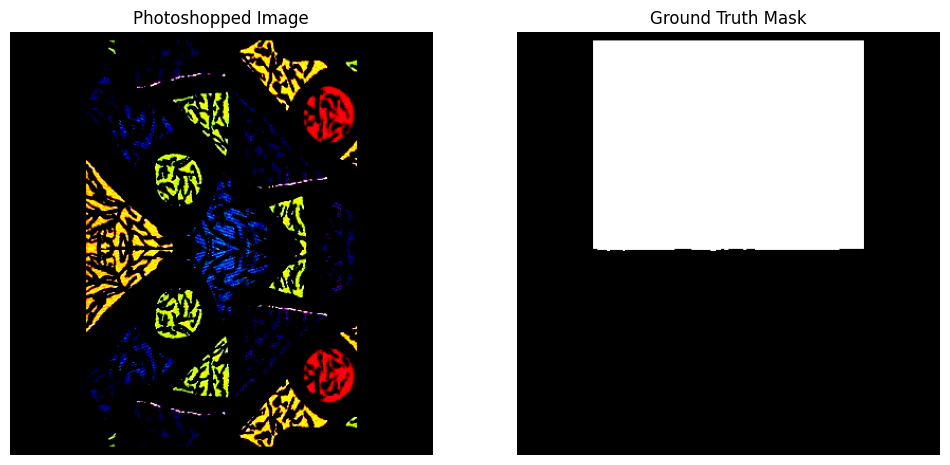

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_sample(train_dataset):
    idx = random.randint(0, len(train_dataset) - 1)  # Get a random index
    photoshopped_image, ground_truth_mask = train_dataset[idx]  # Fetch the data

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Image
    ax[0].imshow(photoshopped_image.numpy().transpose(1, 2, 0))
    ax[0].set_title('Photoshopped Image')
    ax[0].axis('off')

    # Mask
    ax[1].imshow(ground_truth_mask.numpy().squeeze(), cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    plt.show()

# Now, use this function to visualize a sample from the dataset
visualize_sample(train_dataset)


# Creating a ValLoader

In [11]:
import torch
from torchvision import transforms, datasets
import torchvision.transforms.functional as TF
from PIL import Image


val_transforms = transforms.Compose([
    transforms.Normalize(mean=img_mean, std=img_sd),
])


class CustomValDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, val_transforms=None):
        self.dataframe = dataframe
        self.image_transform = val_transforms


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Load images
        photoshopped_path = self.dataframe.iloc[idx]['photoshopped']
        ground_truth_path = self.dataframe.iloc[idx]['ground_truth']

        photoshopped_image = Image.open(photoshopped_path)
        ground_truth_mask = Image.open(ground_truth_path).convert('L')  # Convert to grayscale

        # Transform to tensor
        photoshopped_image = TF.to_tensor(photoshopped_image)
        ground_truth_mask = TF.to_tensor(ground_truth_mask)

        # Normalize
        if self.image_transform is not None:
            photoshopped_image = self.image_transform(photoshopped_image)


        return photoshopped_image, ground_truth_mask

# Now create the dataset and dataloader
val_dataset = CustomValDataset(dataframe=val_df, val_transforms=val_transforms)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Checking if masks are binary

In [12]:
import torch
import numpy as np

# Function to check if masks are binary
def check_if_binary(dataloader):
    # Fetch a single batch
    for photoshopped_images, ground_truth_masks in dataloader:
        # Take the first mask from the batch for simplicity
        sample_mask = ground_truth_masks[0]

        # Convert to numpy array
        mask_array = sample_mask.numpy()

        # Find unique values
        unique_values = np.unique(mask_array)

        # Print unique values
        print("Unique values in the mask:", unique_values)

        # Determine if the mask is binary
        is_binary = np.array_equal(unique_values, [0, 1]) or np.array_equal(unique_values, [0, 255])
        print("Is the mask binary:", is_binary)

        # Check only one batch
        break

# Assuming 'dataloader' is already defined and loaded with your dataset
check_if_binary(val_loader)

Unique values in the mask: [0. 1.]
Is the mask binary: True


# Creating a test-loader

In [13]:
test_transforms = transforms.Compose([
    transforms.Normalize(mean=img_mean, std=img_sd),
])

test_dataset = CustomValDataset(dataframe=test_df, val_transforms=test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Plot a whole batch along with the corresponding ground truth from the train_loader

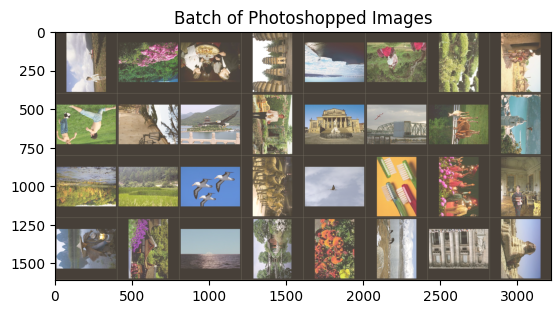

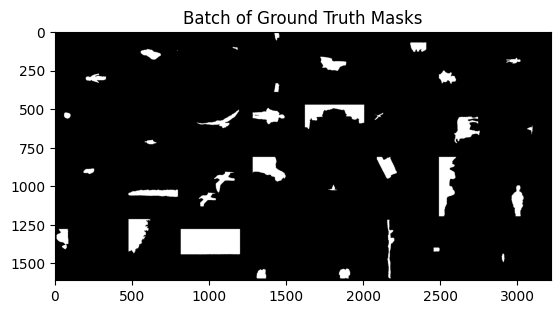

In [14]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

def imshow(img, title=None, is_mask=False):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor image
    if not is_mask:
        mean = np.array([0.485, 0.456, 0.406])  # Normalization mean
        std = np.array([0.229, 0.224, 0.225])  # Normalization std
        img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip to make sure it's between 0 and 1
    plt.imshow(img, cmap='gray' if is_mask else None)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause to update plots

def plot_images_and_masks(train_loader):
    dataiter = iter(train_loader)
    images, masks = next(dataiter)  # Get one batch of images and masks

    # Create a grid from batch of images
    image_grid = torchvision.utils.make_grid(images)
    imshow(image_grid, title="Batch of Photoshopped Images")

    # Create a grid from batch of masks
    mask_grid = torchvision.utils.make_grid(masks)
    imshow(mask_grid, title="Batch of Ground Truth Masks", is_mask=True)

    plt.show()

# Assuming train_loader is already defined and set up correctly
plot_images_and_masks(train_loader)


# Creating the UNet

In [15]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.down1 = self.conv_stage(3, 16)
        self.down2 = self.conv_stage(16, 32)
        self.down3 = self.conv_stage(32, 64)
        self.down4 = self.conv_stage(64, 128)

        # Decoder
        self.up1 = self.up_conv_stage(128, 64)
        self.up2 = self.up_conv_stage(64, 32)
        self.up3 = self.up_conv_stage(32, 16)
        self.up4 = self.up_conv_stage(16,8)

        # Final output layer
        self.final = nn.Sequential(
            nn.Conv2d(8, 1, kernel_size=1),
            #nn.Sigmoid()
        )

    def conv_stage(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def up_conv_stage(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
            #nn.Sigmoid()
        )
    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)

        # Decoder
        x = self.up1(x4)
        x = self.up2(x + x3)
        x = self.up3(x + x2)
        x = self.up4(x + x1)

        return self.final(x)

# Create the model
#model = UNet()
#print(model)


In [16]:
import torch
import torch.nn as nn

class UNet2(nn.Module):
    def __init__(self):
        super(UNet2, self).__init__()
        # Encoder
        self.down1 = self.conv_stage(3, 32)  # Increased filter count
        self.down2 = self.conv_stage(32, 64)
        self.down3 = self.conv_stage(64, 128)
        self.down4 = self.conv_stage(128, 256)

        # Decoder
        self.up1 = self.up_conv_stage(256, 128)
        self.up2 = self.up_conv_stage(128, 64)
        self.up3 = self.up_conv_stage(64, 32)
        self.up4 = self.up_conv_stage(32, 16)

        # Final output layer
        self.final = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            #nn.Sigmoid()
        )

    def conv_stage(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),  # Changed to LeakyReLU
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),  # Additional convolution layer
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def up_conv_stage(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True)  # Changed to LeakyReLU
        )

    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)

        # Decoder
        x = self.up1(x4)
        x = self.up2(x + x3)  # Simple summation, consider using a more sophisticated merging strategy
        x = self.up3(x + x2)
        x = self.up4(x + x1)

        return self.final(x)

# Create and print the model
#model2 = UNet2()
#print(model2)


In [17]:
class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCELoss()

    def dice_loss(self, inputs, targets, smooth=1):
        inputs = inputs.contiguous().view(-1)
        targets = targets.contiguous().view(-1)
        intersection = (inputs * targets).sum()
        dice_coeff = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice_coeff

    def forward(self, inputs, targets):
        dice_loss = self.dice_loss(inputs, targets)
        bce_loss = self.bce(inputs, targets)
        return dice_loss + bce_loss


In [18]:
def iou(outputs, labels, smooth=1):
    outputs = outputs.sigmoid() > 0.5  # Convert logits to binary predictions
    outputs = outputs.float()  # Ensure the output is float for multiplication
    labels = labels.float()    # Ensure the labels are float for multiplication

    intersection = (outputs * labels).sum()  # Multiply element-wise and sum for intersection
    total = (outputs + labels).sum()  # Sum of outputs and labels
    union = total - intersection  # Calculate union

    iou = (intersection + smooth) / (union + smooth)  # Smoothed IoU calculation
    return iou


In [19]:
import torch.optim as optim

# Setup
model = UNet()
model2 = UNet2()
optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer2 = optim.Adam(model2.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()
num_epochs = 50


In [ ]:
#model = UNet()
#path = r'C:\Users\Marcus\Documents\Avancerade NN\Project\best_model_so_far.pth'
#model.load_state_dict(torch.load(path))

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()
num_epochs = 100

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Move the model to the device
    model.to(device)

    best_val_loss = float('inf')
    best_iou = 0
    training_losses = []
    validation_losses = []
    train_iou_scores = []
    iou_scores = []

    scheduler = StepLR(optimizer, step_size=100, gamma=0.5)  # Decays the learning rate by half every step_size epochs

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_iou = 0.0
        for images, masks in train_loader:

            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            total_iou += iou(outputs, masks).item()

        average_train_loss = running_loss / len(train_loader)
        training_losses.append(average_train_loss)
        average_iou = total_iou / len(train_loader)
        train_iou_scores.append(average_iou)

        model.eval()
        val_loss = 0.0
        total_iou = 0.0
        with torch.no_grad():
            for images, masks in val_loader:

                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                total_iou += iou(outputs, masks).item()

        average_val_loss = val_loss / len(val_loader)
        average_iou = total_iou / len(val_loader)
        validation_losses.append(average_val_loss)
        iou_scores.append(average_iou)

        scheduler.step()

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}, IoU: {average_iou:.4f}")

        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            torch.save(model.state_dict(), 'best_model_cont.pth')
            print(f"Saved new best model with validation loss: {best_val_loss:.4f}")

        # Early stopping based on IoU not improving more than a small threshold or decreasing
        if epoch > 1000:  # Start checking only after a few epochs to give the model time to stabilize
            if average_val_loss < best_val_loss * 1.1:  # If current IoU is less than 95% of the best IoU
                print(f"IoU decreased more than 5%. Stopping training early.")
                break



    return training_losses, validation_losses, iou_scores, train_iou_scores






In [ ]:
# Execute the training and validation
# First, set the device based on the availability of CUDA
model = UNet()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()
num_epochs = 200

train_losses, validation_losses, iou_scores, train_iou_scores = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

In [42]:
#torch.save(model.state_dict(), 'model_weights.pth')


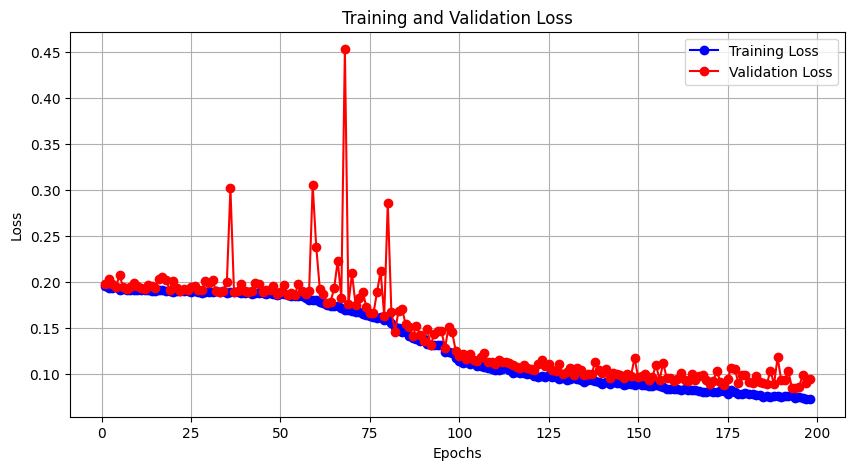

In [36]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, validation_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, validation_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming train_losses and validation_losses are the arrays you obtained from the training function
plot_losses(train_losses[2:], validation_losses[2:])

In [21]:
model.load_state_dict(torch.load('model_best.pth'))

<All keys matched successfully>

337


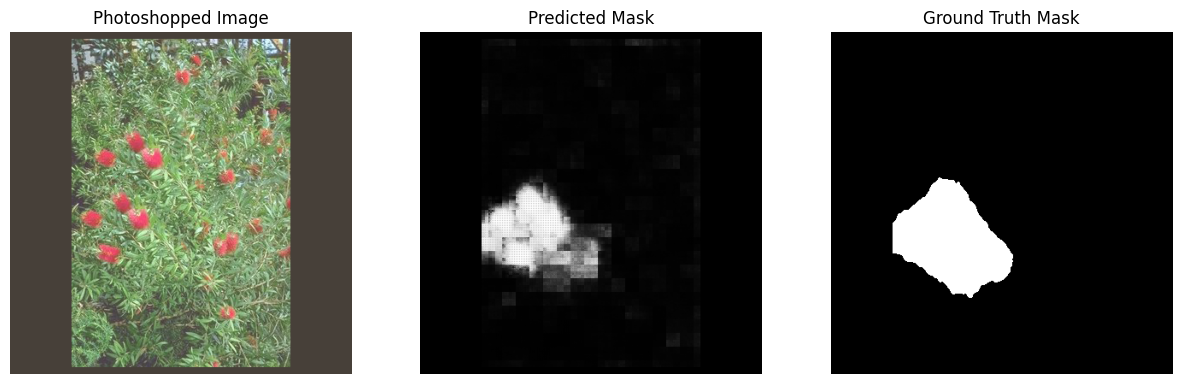

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

model.to('cpu')
model2.to('cpu')

def visualize_prediction(dataset, model, index=0):
    # Fetch the image and mask from the dataset
    photoshopped_image, ground_truth_mask = dataset[index]

    # Model prediction
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        photoshopped_image = photoshopped_image.unsqueeze(0)  # Add batch dimension
        prediction = model(photoshopped_image)
        predicted_mask = torch.sigmoid(prediction).squeeze(0).squeeze(0)  # Remove batch dimension and extra channel

    # Convert the tensors to numpy arrays for visualization
    image_np = photoshopped_image.squeeze(0).numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean  # Unnormalize
    image_np = np.clip(image_np, 0, 1)  # Clip to ensure it's between 0 and 1

    predicted_mask_np = predicted_mask.cpu().numpy()
    ground_truth_mask_np = ground_truth_mask.squeeze(0).cpu().numpy()

    # Set up the matplotlib figure and axes
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    titles = ['Photoshopped Image', 'Predicted Mask', 'Ground Truth Mask']

    # Display Photoshopped Image
    axes[0].imshow(image_np)
    axes[0].set_title(titles[0])
    axes[0].axis('off')

    # Display Predicted Mask
    axes[1].imshow(predicted_mask_np, cmap='gray')
    axes[1].set_title(titles[1])
    axes[1].axis('off')

    # Display Ground Truth Mask
    axes[2].imshow(ground_truth_mask_np, cmap='gray')
    axes[2].set_title(titles[2])
    axes[2].axis('off')

    plt.show()

# Assuming model and dataset are already defined and initialized
# Visualize the first image in the dataset
data = test_dataset
print(len(data))
random_index = random.randint(0, len(data) - 1)
visualize_prediction(data, model, index=random_index)


In [55]:
#model2 = UNet2()
optimizer = optim.Adam(model2.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()
num_epochs = 50

train_losses, validation_losses, iou_scores, train_iou_scores = train_and_validate(model2, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)
model2.to('cpu')

Epoch 1/50, Train Loss: 0.0824, Validation Loss: 0.1195, IoU: 0.5370
Saved new best model with validation loss: 0.1195
Epoch 2/50, Train Loss: 0.0831, Validation Loss: 0.1066, IoU: 0.5632
Saved new best model with validation loss: 0.1066
Epoch 3/50, Train Loss: 0.0782, Validation Loss: 0.1159, IoU: 0.5315
Epoch 4/50, Train Loss: 0.0799, Validation Loss: 0.1112, IoU: 0.5356
Epoch 5/50, Train Loss: 0.0803, Validation Loss: 0.0919, IoU: 0.5829
Saved new best model with validation loss: 0.0919
Epoch 6/50, Train Loss: 0.0800, Validation Loss: 0.0898, IoU: 0.5836
Saved new best model with validation loss: 0.0898
Epoch 7/50, Train Loss: 0.0780, Validation Loss: 0.0988, IoU: 0.5551
Epoch 8/50, Train Loss: 0.0779, Validation Loss: 0.0896, IoU: 0.6009
Saved new best model with validation loss: 0.0896
Epoch 9/50, Train Loss: 0.0781, Validation Loss: 0.0934, IoU: 0.5645
Epoch 10/50, Train Loss: 0.0787, Validation Loss: 0.1019, IoU: 0.5871
Epoch 11/50, Train Loss: 0.0785, Validation Loss: 0.0954, I

KeyboardInterrupt: 

In [28]:
#torch.save(model2.state_dict(), 'model2_weights.pth')

In [54]:
model2.load_state_dict(torch.load('model2_over.pth'))

<All keys matched successfully>

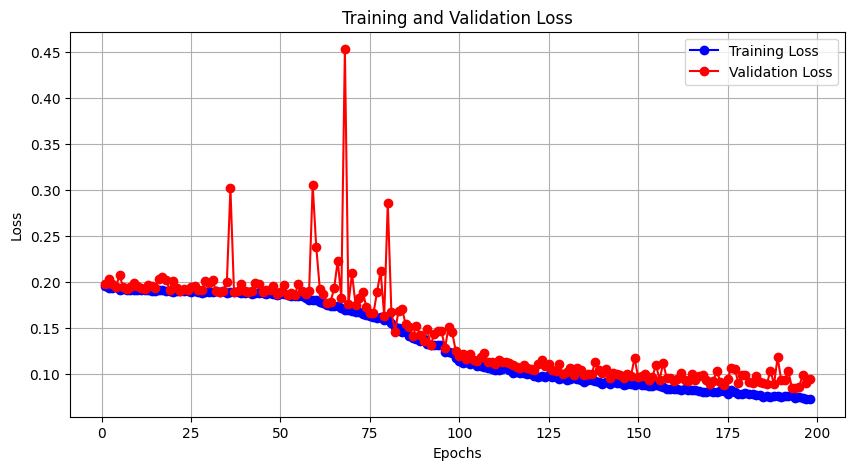

In [38]:
plot_losses(train_losses[2:], validation_losses[2:])

337


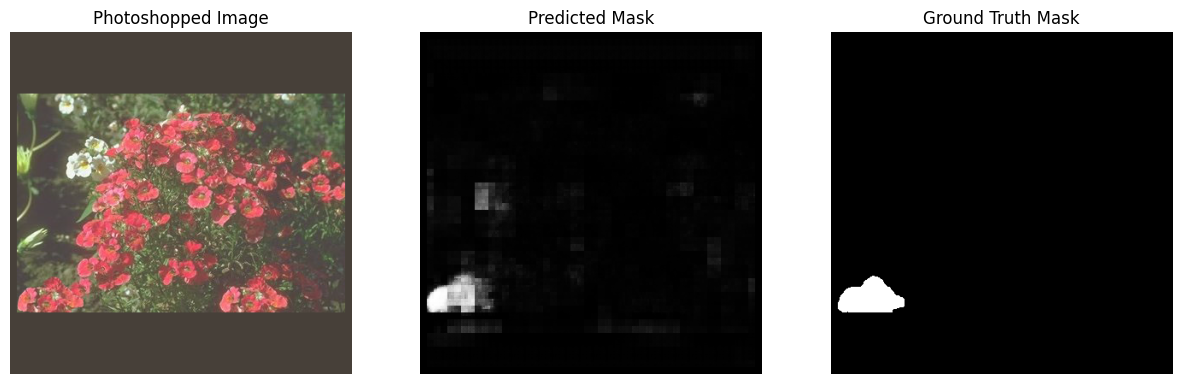

In [52]:
data = test_dataset
print(len(data))
random_index = random.randint(0, len(data) - 1)
model2.to('cpu')
visualize_prediction(data, model2, index=random_index)